## 🚀 XGBoost Classifier Notebook

This notebook build and evaluate an XGBoost classifier step-by-step.

### ⚙️ Configuration

#### 🔧 Overview

Setting up libraries and global settings to ensure smooth execution.

- 📦 Import essential libraries: xgboost, pandas, numpy, and sklearn.
- 🎲 Set a random seed for reproducibility.
- 💻 GPU set up for tensorflow.


In [1]:
import os
import logging
import tensorflow as tf

2024-11-25 22:15:53.135750: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 22:15:53.145310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732594553.157437   40034 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732594553.161053   40034 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 22:15:53.173166: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_GPU_THREAD_COUNT"] = "2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
tf.get_logger().setLevel(logging.ERROR)

In [4]:
import numpy as np
import xgboost as xgb

Setting a random seed for consistent results.


In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print("GPU Devices:", tf.config.list_physical_devices("GPU"))

Num GPUs Available:  1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=1024 * 4)],
        )

    except RuntimeError as e:
        print(e)

## 📂 Data Loader

### 🔍 Data Exploration and Preparation

1. Load the dataset into a pandas DataFrame.
2. Preprocess data:
   - 🧹 Handle missing values.
   - 🔄 Encode categorical variables.
   - 📏 Normalize numerical features if necessary.
3. Split the dataset: divide data into training and testing sets (80% training, 20% testing).


In [8]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [9]:
class DataLoader:
    """
    Data loader for the cow count dataset

    Attributes:
        data_root (str): Root directory containing numbered folders (0-12 cows)
        expected_dirs (set): Set of expected directories
    """

    def __init__(self, data_root: str):
        """
        Initialize DataLoader ensuring coverage of all directories 0-12

        Args:
            data_root: Root directory containing numbered folders (0-12 cows)
        """
        self.data_root = Path(data_root)
        self.expected_dirs = set(str(i) for i in range(13))

    def verify_directories(self) -> set:
        """
        Verify all expected directories exist and report missing ones

        Returns:
            Set of existing directories
        """
        existing_dirs = set(
            d.name for d in self.data_root.glob("*") if d.is_dir() and d.name.isdigit()
        )

        missing_dirs = self.expected_dirs - existing_dirs
        extra_dirs = existing_dirs - self.expected_dirs

        if missing_dirs:
            print(
                f"Warning: Missing directories for cow counts: {sorted(missing_dirs)}"
            )

        if extra_dirs:
            print(f"Warning: Unexpected directories found: {sorted(extra_dirs)}")

        return existing_dirs

    def count_images_in_dir(self, dir_path: str) -> tuple:
        """
        Count the number of images in a directory and report unreadable images

        Args:
            dir_path (str): Path to directory containing images

        Returns:
            Tuple of total images and unreadable images
        """

        total = 0
        unreadable = 0

        for img_path in dir_path.glob("*jpg.rf.*"):
            total += 1
            try:
                tf.io.read_file(str(img_path))

            except tf.errors.InvalidArgumentError:
                unreadable += 1
                print(f"Warning: Unreadable image found: {img_path}")

        return total, unreadable

    def load_data(self) -> pd.DataFrame:
        """
        Loads data from the dataset into a DataFrame and provides summary statistics

        Returns:
            DataFrame containing image paths, cow counts, and timestamps
        """

        existing_dirs = self.verify_directories()
        if not existing_dirs:
            print("No directories found. Exiting.")
            return

        data = []
        for dir_name in sorted(self.expected_dirs):
            dir_path = self.data_root / dir_name

            if not dir_path.exists():
                print(f"Directory {dir_name} (cows) - Not found")
                continue

            total, unreadable = self.count_images_in_dir(dir_path)
            print(
                f"Directory {dir_name} (cows) - {total} images found, {unreadable} unreadable"
            )

            for img_path in dir_path.glob("*jpg.rf.*"):
                try:
                    timestamp_str = img_path.name.split("_jpg.rf")[0]
                    timestamp = pd.to_datetime(
                        timestamp_str, format="%Y-%m-%d-%H-%M-%S"
                    )

                    data.append(
                        {
                            "image_path": str(img_path),
                            "cow_count": int(dir_name),
                            "timestamp": timestamp,
                            "hour": timestamp.hour,
                        }
                    )
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")

        df = pd.DataFrame(data)

        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, x="cow_count", order=range(13))
        plt.title("Distribution of Images by Cow Count")
        plt.xlabel("Number of Cows")
        plt.ylabel("Number of Images")
        plt.xticks(range(13))
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, x="hour")
        plt.title("Distribution of Images by Hour")
        plt.xlabel("Hour of Day")
        plt.ylabel("Number of Images")
        plt.show()

        return df

In [10]:
def verify_dataset(data_root: str) -> pd.DataFrame:
    """
    Auxiliary function to verify dataset completeness and quality
    of the given dataset.

    Args:
        data_root (str): Path to the dataset root directory

    Returns:
        pd.DataFrame: DataFrame containing image paths, cow counts, and timestamps
    """

    loader = DataLoader(data_root)
    df = loader.load_data()

    missing_counts = set(range(13)) - set(df["cow_count"].unique())
    if missing_counts:
        print(f"\nWarning: No images found for cow counts: {sorted(missing_counts)}")

    print("\nChecking for potential data quality issues...")

    df["time_diff"] = df["timestamp"].diff()
    large_gaps = df[df["time_diff"] > pd.Timedelta(hours=1)]
    if not large_gaps.empty:
        print(f"\nFound {len(large_gaps)} time gaps larger than 1 hour")
        print("Sample gaps:")
        print(large_gaps[["timestamp", "time_diff"]].head())

    missing_files = df[~df["image_path"].apply(lambda x: Path(x).exists())]
    if not missing_files.empty:
        print(f"\nWarning: {len(missing_files)} image files are missing")
        print("Sample missing files:")
        print(missing_files["image_path"].head())

    return df

## 🏗️ Model Creation

### 🛠️ Building the XGBoost Classifier

Define the model and its key parameters:

- 🔧 Learning Rate: 0.1
- 🌳 Max Depth: 6
- 🔢 Number of Estimators: 100


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from typing import List, Optional, Tuple, Union, Dict, Any

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tqdm import tqdm
from PIL import Image, ImageOps, ImageEnhance

In [12]:
class ImagePreprocessor:
    """
    Standalone image preprocessing utility with multiple augmentation strategies

    Attributes:
        img_size (Tuple[int, int]): Target image size (height, width)
    """

    def __init__(self, img_size: Tuple[int, int] = (224, 224)):
        self.img_size = img_size

    def preprocess_tensorflow(self, image_path: str, augment: bool = True) -> tf.Tensor:
        """
        Tensorflow-based image preprocessing pipeline with data augmentation.

        Args:
            image_path (str): Path to the image file
            augment (bool): Whether to apply data augmentation

        Returns:
            tf.Tensor: Processed image tensor
        """

        img_raw = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
        img = tf.image.resize(img, self.img_size, method=tf.image.ResizeMethod.LANCZOS3)

        img = tf.cast(img, tf.float32)

        if augment:
            img = tf.image.random_brightness(img, max_delta=0.1)
            img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
            img = tf.image.random_flip_left_right(img)
            img = tf.image.rot90(img)

        img = (img - 127.5) / 127.5
        return img

    def preprocess_pillow(self, image_path: str, augment: bool = True) -> np.ndarray:
        """
        Pillow-based image preprocessing pipeline with data augmentation.

        Args:
            image_path (str): Path to the image file
            augment (bool): Whether to apply data augmentation

        Returns:
            np.ndarray: Processed image array
        """

        try:
            img = Image.open(image_path).convert("RGB")
            img = img.resize(self.img_size, Image.LANCZOS)

            if augment:
                augmentations = [
                    lambda: ImageEnhance.Brightness(img).enhance(
                        np.random.uniform(0.9, 1.1)
                    ),
                    lambda: ImageEnhance.Contrast(img).enhance(
                        np.random.uniform(0.9, 1.1)
                    ),
                    lambda: ImageOps.mirror(img),
                    lambda: img.rotate(
                        np.random.uniform(-5, 5), resample=Image.BICUBIC
                    ),
                ]

                for aug in augmentations:
                    if np.random.random() > 0.5:
                        img = aug()

            img_array = np.array(img, dtype=np.float32)
            return (img_array - 127.5) / 127.5

        except Exception as e:
            print(f"Error processing image {image_path}: {str(e)}")
            return np.zeros((*self.img_size, 3), dtype=np.float32)

In [13]:
class FeatureExtractor:
    """
    Configurable feature extraction using transfer learing with ResNet50V2

    Attributes:
        img_size (Tuple[int, int]): Target image size (height, width)
        freeze_layers (int): Number of layers to freeze from the base model
    """

    def __init__(self, img_size: Tuple[int, int] = (224, 224), freeze_layers: int = 70):
        self.img_size = img_size
        self.feature_extractor = self._build_resnet_model(freeze_layers)
        self.scaler = StandardScaler()

    def _build_resnet_model(self, freeze_layers: int) -> tf.keras.Model:
        """
        Build a ResNet50V2 model with advanced attention mechanism.

        Args:
            freeze_layers (int): Number of layers to freeze from the base model

        Returns:
            tf.keras.Model: Feature extraction model
        """

        base_model = tf.keras.applications.ResNet50V2(
            include_top=False,
            weights="imagenet",
            input_shape=(*self.img_size, 3),
            pooling=None,
        )

        for layer in base_model.layers[:-freeze_layers]:
            layer.trainable = False

        x = base_model.output
        attention = self._create_attention_module(x)

        avg_pool = tf.keras.layers.GlobalAveragePooling2D()(attention)
        max_pool = tf.keras.layers.GlobalMaxPooling2D()(attention)
        x = tf.keras.layers.Concatenate()([avg_pool, max_pool])

        x = tf.keras.layers.Dense(1024, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.4)(x)

        return tf.keras.Model(inputs=base_model.input, outputs=x)

    def _create_attention_module(self, x: tf.Tensor) -> tf.Tensor:
        """
        Create an attention module for the feature extraction model.

        Args:
            x (tf.Tensor): Input tensor

        Returns:
            tf.Tensor: Output tensor with attention mechanism
        """

        attention_layers = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(256, (1, 1)),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Activation("relu"),
                tf.keras.layers.Conv2D(1, (1, 1)),
                tf.keras.layers.Activation("sigmoid"),
            ]
        )

        for layer in attention_layers.layers:
            x = layer(x)

        return tf.keras.layers.Multiply()([x, x])

    def extract_features(
        self,
        image_paths: List[str],
        preprocessor: ImagePreprocessor,
        batch_size: int = 32,
        augment: bool = True,
    ) -> np.ndarray:
        """
        Feature extraction with configurable preprocessing.

        Args:
            image_paths (List[str]): Paths to images
            preprocessor (ImagePreprocessor): Preprocessing strategy
            batch_size (int): Batch size for extraction
            augment (bool): Whether to apply augmentation

        Returns:
            np.ndarray: Extracted and scaled features
        """
        dataset = tf.data.Dataset.from_tensor_slices(image_paths)
        dataset = dataset.map(
            lambda x: preprocessor.preprocess_tensorflow(x, augment),
            num_parallel_calls=tf.data.AUTOTUNE,
        )

        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        features = []

        for batch in tqdm(dataset, desc="Extracting Features"):
            batch_features = self.feature_extractor.predict(batch, verbose=0)
            features.append(batch_features)

        features = np.concatenate(features, axis=0)

        if augment:
            features = self.scaler.fit_transform(features)
        else:
            features = self.scaler.transform(features)

        return features

In [14]:
import random

In [15]:
class EnsembleRegressor:
    """
    Flexible ensamble regressor with multiple base models and blending strategies
    """

    def __init__(
        self,
        model_type: str = "xgboost",
        num_models: int = 10,
        learning_rate: float = 0.03,
        n_estimators: int = 200,
        max_bin: int = 256,
        bagging_fraction: float = 0.8,
    ):
        self.model_type = model_type
        self.num_models = num_models
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_bin = max_bin
        self.bagging_fraction = bagging_fraction

        self.models = self._initialize_models()

    def _initialize_models(
        self,
    ) -> List[Union[xgb.XGBRegressor, GradientBoostingRegressor]]:
        """
        Initialize multiple base models for the ensemble regressor

        Returns:
            List: List of base models
        """

        models = []
        for i in range(self.num_models):
            depth_variation = random.choice([4, 5, 6, 7])
            subsample_variation = random.uniform(0.7, 0.9)

            if self.model_type == "xgboost":
                model = XGBRegressor(
                    n_estimators=self.n_estimators,
                    learning_rate=self.learning_rate * random.uniform(0.9, 1.1),
                    max_depth=depth_variation,
                    subsample=subsample_variation,
                    colsample_bytree=random.uniform(0.7, 1.0),
                    tree_method="hist",
                    device="cuda",
                    objective="reg:squarederror",
                    random_state=i,
                    max_bin=self.max_bin,
                )

            else:
                model = GradientBoostingRegressor(
                    n_estimators=self.n_estimators,
                    learning_rate=self.learning_rate * random.uniform(0.9, 1.1),
                    max_depth=depth_variation,
                    min_samples_split=random.randint(2, 10),
                    subsample=subsample_variation,
                    random_state=i,
                )

            models.append(model)

        return models

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        sample_weights: Optional[np.ndarray] = None,
        additional_learning_params: Optional[Dict] = None,
    ):
        """
        Fit the ensemble regressor on the given data

        Args:
            X (np.ndarray): Input features
            y (np.ndarray): Target labels
            sample_weights (np.ndarray): Sample weights for training
            additional_learning_params (Dict): Additional parameters for fitting
        """

        predictions = []
        additional_params = additional_learning_params or {}

        for i, model in tqdm(enumerate(self.models), desc="Fitting models"):
            if sample_weights is not None:
                mask = np.random.choice(
                    len(X),
                    size=int(len(X) * self.bagging_fraction),
                    replace=False,
                    p=sample_weights / sample_weights.sum(),
                )

            else:
                mask = np.random.choice(
                    len(X),
                    size=int(len(X) * self.bagging_fraction),
                    replace=False,
                )

            X_subset = X[mask]
            y_subset = y[mask]

            sample_weights_subset = (
                sample_weights[mask] if sample_weights is not None else None
            )

            model.fit(
                X_subset,
                y_subset,
                sample_weight=sample_weights_subset,
                **additional_params
            )

            predictions.append(model.predict(X))

        return np.array(predictions)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Make predictions using the ensemble regressor

        Args:
            X (np.ndarray): Input features

        Returns:
            np.ndarray: Predicted labels
        """

        predictions = [model.predict(X) for model in self.models]
        weights = [1 / (np.std(pred) + 1e-8) for pred in predictions]
        weighted_predictions = np.average(predictions, weights=weights, axis=0)

        return weighted_predictions

In [16]:
from sklearn.model_selection import StratifiedKFold

In [17]:
class CowCounter:
    def __init__(
        self,
        img_size: Tuple[int, int] = (224, 224),
        model_type: str = "xgboost",
        freeze_layers: int = 70,
        cross_validation_splits: int = 5,
    ):
        self.img_size = img_size
        self.preprocessor = ImagePreprocessor(img_size)
        self.feature_extractor = FeatureExtractor(img_size, freeze_layers)

        self.ensemble_regressor = EnsembleRegressor(
            model_type=model_type,
            num_models=15,
            learning_rate=0.02,
            bagging_fraction=0.75,
        )

        self.cross_validation_splits = cross_validation_splits
        self.cv_strategy = StratifiedKFold(
            n_splits=cross_validation_splits,
            shuffle=True,
            random_state=42,
        )

        self.training_history = {
            "cv_scores": [],
        }

        self.best_model_params = {
            "best_mae": float("inf"),
            "best_rmse": float("inf"),
            "fold": None,
        }

    def train(
        self,
        train_images_paths: List[str],
        train_counts: List[int],
        batch_size: int = 32,
    ) -> None:
        """
        Train the cow counter model using cross-validation

        Args:
            train_images_paths (List[str]): List of paths to training images
            train_counts (List[int]): List of ground truth cow counts
            batch_size (int, optional): Batch size for feature extraction. Defaults to 32
        """
        X_train = self.feature_extractor.extract_features(
            train_images_paths, self.preprocessor, batch_size=batch_size
        )

        y_train = np.array(train_counts)

        unique_counts = np.unique(y_train)
        weights = compute_class_weight(
            class_weight="balanced", classes=unique_counts, y=y_train
        )

        sample_weights = np.zeros_like(y_train, dtype=float)
        for count, weight in zip(unique_counts, weights):
            sample_weights[y_train == count] = weight

        for i, (train_idx, valid_idx) in enumerate(
            self.cv_strategy.split(X_train, y_train)
        ):
            X_tr, X_val = X_train[train_idx], X_train[valid_idx]
            y_tr, y_val = y_train[train_idx], y_train[valid_idx]
            sample_weights_tr = sample_weights[train_idx]

            predictions = self.ensemble_regressor.fit(
                X_tr,
                y_tr,
                sample_weights_tr,
                {"eval_set": [(X_val, y_val)]},
            )

            mae = mean_absolute_error(y_val, predictions)
            rmse = np.sqrt(mean_squared_error(y_val, predictions))

            self.training_history["cv_scores"].append((mae, rmse))
            print(f"Fold {i+1} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

            if mae < self.best_model_params["best_mae"]:
                self.best_model_params["best_mae"] = mae
                self.best_model_params["best_rmse"] = rmse
                self.best_model_params["fold"] = i

        print(
            f"\nBest model found in fold {self.best_model_params['fold']+1} "
            f"with MAE: {self.best_model_params['best_mae']:.2f}"
        )

    def predict(self, image_paths: List[str], batch_size: int = 32) -> np.ndarray:
        """
        Predict cow counts for a list of image paths using the trained model

        Args:
            image_paths (List[str]): List of image paths
            batch_size (int): Batch size for prediction

        Returns:
            np.ndarray: Predicted cow counts
        """

        features = self.feature_extractor.extract_features(
            image_paths, self.preprocessor, batch_size=batch_size, augment=False
        )

        predictions = self.ensemble_regressor.predict(features)

        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.mean(predictions, axis=0)

        return np.round(predictions).flatten()

## 📊 Visualizations


In [18]:
def plot_cow_distribution(data: pd.DataFrame):
    """
    Plots the cow distribution in the dataset (label distribution)

    Args:
        data (pd.DataFrame): DataFrame containing image paths, cow counts, and timestamps
    """

    plt.figure(figsize=(12, 6))

    sns.countplot(data=data, x="cow_count")
    plt.title("Distribution of Images by Cow Count")
    plt.xlabel("Number of Cows")
    plt.ylabel("Number of Images")
    plt.show()

In [19]:
def plot_distribution_by_hour(data: pd.DataFrame):
    """
    Plots the distribution by hour in the dataset using the
    timestamp field of the dataframe.

    Args:
        data (pd.DataFrame): DataFrame containing image paths, cow counts, and timestamps
    """

    data_df = data.copy()
    data_df["hour"] = data_df["timestamp"].dt.hour

    plt.figure(figsize=(12, 6))
    sns.countplot(data=data_df, x="hour")
    plt.title("Distribution of Images by Hour")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Number of Images")
    plt.show()

In [20]:
def plot_confusion_matrix(data: pd.DataFrame):
    """
    Plots the confusion matrix for the given data

    Args:
        data (pd.DataFrame): DataFrame containing true and predicted cow counts

    Raises:
        ImportError: If seaborn is not installed
    """

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(data["true_count"], data["predicted_count"])
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

## Training Config


In [21]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [22]:
def train_cow_counter(
    data_root: str,
    output_dir: str = "cow_counter_output",
    img_size: tuple = (224, 224),
    batch_size: int = 32,
    use_xgboost: bool = True,
    test_size: float = 0.2,
    time_based_split: bool = True,
) -> Tuple[CowCounter, dict]:
    """
    Train function for the Cow Counter model. It builds the model, trains it
    on the given data, and evaluates it using the test set.

    Args:
        data_root (str): Path to the dataset root directory
        output_dir (str): Path to the output directory
        img_size (tuple): Size of input images
        batch_size (int): Batch size for training
        use_xgboost (bool): Whether to use XGBoost or GradientBoostingRegressor
        test_size (float): Size of the test set
        time_based_split (bool): Whether to split the data based on time

    Returns:
        CowCounter: Trained CowCounter model
        dict: Evaluation results
    """

    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    data_loader = DataLoader(data_root)
    data_df = data_loader.load_data()

    if time_based_split:
        split_time = data_df["timestamp"].quantile(1 - test_size)
        train_df = data_df[data_df["timestamp"] < split_time]
        test_df = data_df[data_df["timestamp"] >= split_time]

        X_train = train_df["image_path"].values
        y_train = train_df["cow_count"].values

        X_test = test_df["image_path"].values
        y_test = test_df["cow_count"].values

    else:
        X_train, X_test, y_train, y_test = train_test_split(
            data_df["image_path"].values,
            data_df["cow_count"].values,
            test_size,
            random_state=42,
            stratify=data_df["cow_count"].values,
        )

    cow_counter = CowCounter(
        img_size=img_size,
        model_type="xgboost" if use_xgboost else "gradient_boosting",
    )

    cow_counter.train(X_train, y_train, batch_size=batch_size)
    y_pred = cow_counter.predict(X_test)

    results = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred, average="weighted"),
        "mae": mean_absolute_error(y_test, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
    }

    return cow_counter, results

## Main Execution


### Hyperparams


In [23]:
DATA_ROOT = "../../../data/extended/day/"
OUTPUT_DIR = "cow_counter_output"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
USE_XGBOOST = True
TIME_BASED_SPLIT = True

### Execution


2024-11-25 22:15:55.529098: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1732594555.529157   40034 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Directory 0 (cows) - 206 images found, 0 unreadable
Directory 1 (cows) - 385 images found, 0 unreadable
Directory 10 (cows) - 67 images found, 0 unreadable
Directory 11 (cows) - 37 images found, 0 unreadable
Directory 12 (cows) - 5 images found, 0 unreadable
Directory 2 (cows) - 543 images found, 0 unreadable
Directory 3 (cows) - 635 images found, 0 unreadable
Directory 4 (cows) - 584 images found, 0 unreadable
Directory 5 (cows) - 646 images found, 0 unreadable
Directory 6 (cows) - 522 images found, 0 unreadable
Directory 7 (cows) - 342 images found, 0 unreadable
Directory 8 (cows) - 241 images found, 0 unreadable
Directory 9 (cows) - 155 images found, 0 unreadable


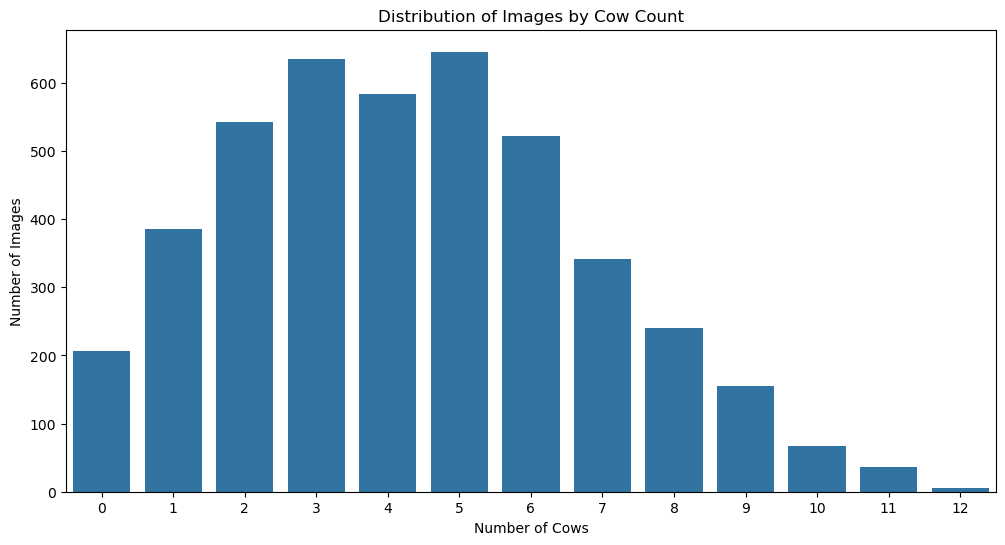

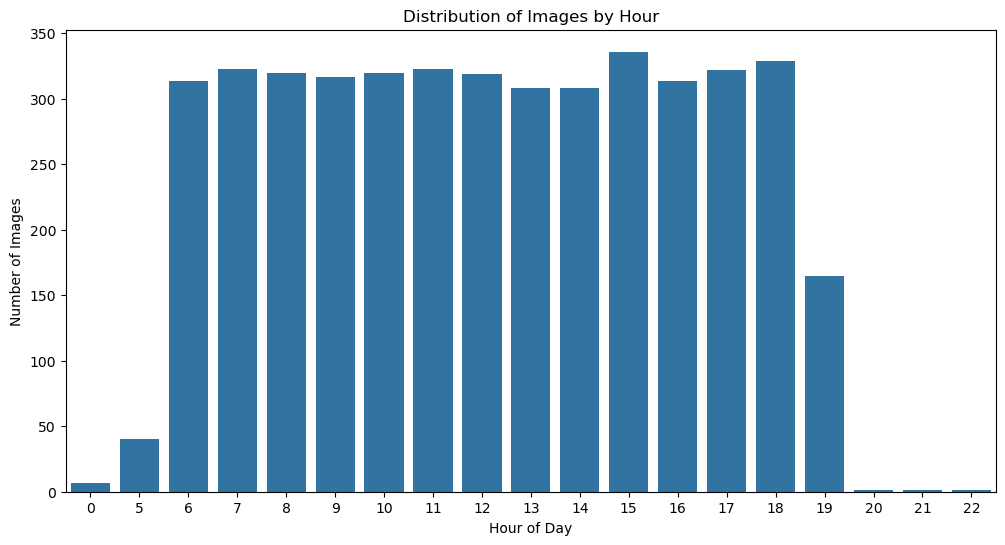

Extracting Features:   0%|          | 0/110 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1732594558.916657   40090 service.cc:148] XLA service 0x7fcfd8001820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732594558.916696   40090 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-25 22:15:58.963331: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732594559.238898   40090 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1732594564.498662   40090 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extracting Features: 100%|██████████| 110/110 [00:25<00:00,  4.31it/s]
Fitting models: 0it [00:00, ?it/s]

[0]	validation_0-rmse:2.88436
[1]	validation_0-rmse:2.86556
[2]	validation_0-rmse:2.84698
[3]	validation_0-rmse:2.82976
[4]	validation_0-rmse:2.81495
[5]	validation_0-rmse:2.80118
[6]	validation_0-rmse:2.78764
[7]	validation_0-rmse:2.77278
[8]	validation_0-rmse:2.75879
[9]	validation_0-rmse:2.74651
[10]	validation_0-rmse:2.73423
[11]	validation_0-rmse:2.72197
[12]	validation_0-rmse:2.71147
[13]	validation_0-rmse:2.69948
[14]	validation_0-rmse:2.69012
[15]	validation_0-rmse:2.68056
[16]	validation_0-rmse:2.66964
[17]	validation_0-rmse:2.66196
[18]	validation_0-rmse:2.65321
[19]	validation_0-rmse:2.64688
[20]	validation_0-rmse:2.63755
[21]	validation_0-rmse:2.63076
[22]	validation_0-rmse:2.62218
[23]	validation_0-rmse:2.61457
[24]	validation_0-rmse:2.60731
[25]	validation_0-rmse:2.60310
[26]	validation_0-rmse:2.59662
[27]	validation_0-rmse:2.58931
[28]	validation_0-rmse:2.58301
[29]	validation_0-rmse:2.57663
[30]	validation_0-rmse:2.57094
[31]	validation_0-rmse:2.56784
[32]	validation_0-

/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:16:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
Fitting models: 1it [00:04,  4.94s/it]

[0]	validation_0-rmse:2.89999
[1]	validation_0-rmse:2.88631
[2]	validation_0-rmse:2.87229
[3]	validation_0-rmse:2.85947
[4]	validation_0-rmse:2.84681
[5]	validation_0-rmse:2.83649
[6]	validation_0-rmse:2.82644
[7]	validation_0-rmse:2.81548
[8]	validation_0-rmse:2.80586
[9]	validation_0-rmse:2.79441
[10]	validation_0-rmse:2.78628
[11]	validation_0-rmse:2.77602
[12]	validation_0-rmse:2.76777
[13]	validation_0-rmse:2.75948
[14]	validation_0-rmse:2.75149
[15]	validation_0-rmse:2.74448
[16]	validation_0-rmse:2.73793
[17]	validation_0-rmse:2.73215
[18]	validation_0-rmse:2.72567
[19]	validation_0-rmse:2.72027
[20]	validation_0-rmse:2.71346
[21]	validation_0-rmse:2.70652
[22]	validation_0-rmse:2.70157
[23]	validation_0-rmse:2.69482
[24]	validation_0-rmse:2.68970
[25]	validation_0-rmse:2.68424
[26]	validation_0-rmse:2.67944
[27]	validation_0-rmse:2.67349
[28]	validation_0-rmse:2.67062
[29]	validation_0-rmse:2.66769
[30]	validation_0-rmse:2.66425
[31]	validation_0-rmse:2.66000
[32]	validation_0-

Fitting models: 2it [00:07,  3.45s/it]

[0]	validation_0-rmse:2.89110
[1]	validation_0-rmse:2.87227
[2]	validation_0-rmse:2.85873
[3]	validation_0-rmse:2.84587
[4]	validation_0-rmse:2.83123
[5]	validation_0-rmse:2.81499
[6]	validation_0-rmse:2.80078
[7]	validation_0-rmse:2.78585
[8]	validation_0-rmse:2.77301
[9]	validation_0-rmse:2.75955
[10]	validation_0-rmse:2.74763
[11]	validation_0-rmse:2.73404
[12]	validation_0-rmse:2.72131
[13]	validation_0-rmse:2.71013
[14]	validation_0-rmse:2.69841
[15]	validation_0-rmse:2.68881
[16]	validation_0-rmse:2.67939
[17]	validation_0-rmse:2.67232
[18]	validation_0-rmse:2.66161
[19]	validation_0-rmse:2.65154
[20]	validation_0-rmse:2.64386
[21]	validation_0-rmse:2.63663
[22]	validation_0-rmse:2.62944
[23]	validation_0-rmse:2.62144
[24]	validation_0-rmse:2.61348
[25]	validation_0-rmse:2.60691
[26]	validation_0-rmse:2.60075
[27]	validation_0-rmse:2.59508
[28]	validation_0-rmse:2.59086
[29]	validation_0-rmse:2.58579
[30]	validation_0-rmse:2.57932
[31]	validation_0-rmse:2.57629
[32]	validation_0-

Fitting models: 3it [00:11,  3.81s/it]

[0]	validation_0-rmse:2.90482
[1]	validation_0-rmse:2.88938
[2]	validation_0-rmse:2.87394
[3]	validation_0-rmse:2.85886
[4]	validation_0-rmse:2.84381
[5]	validation_0-rmse:2.82951
[6]	validation_0-rmse:2.81853
[7]	validation_0-rmse:2.80569
[8]	validation_0-rmse:2.79324
[9]	validation_0-rmse:2.78239
[10]	validation_0-rmse:2.77314
[11]	validation_0-rmse:2.76365
[12]	validation_0-rmse:2.75442
[13]	validation_0-rmse:2.74354
[14]	validation_0-rmse:2.73539
[15]	validation_0-rmse:2.72667
[16]	validation_0-rmse:2.71872
[17]	validation_0-rmse:2.71028
[18]	validation_0-rmse:2.70270
[19]	validation_0-rmse:2.69599
[20]	validation_0-rmse:2.68946
[21]	validation_0-rmse:2.68212
[22]	validation_0-rmse:2.67650
[23]	validation_0-rmse:2.66996
[24]	validation_0-rmse:2.66257
[25]	validation_0-rmse:2.65609
[26]	validation_0-rmse:2.65111
[27]	validation_0-rmse:2.64532
[28]	validation_0-rmse:2.63629
[29]	validation_0-rmse:2.63049
[30]	validation_0-rmse:2.62451
[31]	validation_0-rmse:2.62038
[32]	validation_0-

Fitting models: 4it [00:14,  3.64s/it]

[0]	validation_0-rmse:2.89435
[1]	validation_0-rmse:2.87905
[2]	validation_0-rmse:2.86609
[3]	validation_0-rmse:2.85194
[4]	validation_0-rmse:2.83793
[5]	validation_0-rmse:2.82677
[6]	validation_0-rmse:2.81474
[7]	validation_0-rmse:2.80268
[8]	validation_0-rmse:2.78968
[9]	validation_0-rmse:2.77663
[10]	validation_0-rmse:2.76788
[11]	validation_0-rmse:2.75878
[12]	validation_0-rmse:2.74957
[13]	validation_0-rmse:2.74145
[14]	validation_0-rmse:2.73262
[15]	validation_0-rmse:2.72433
[16]	validation_0-rmse:2.71538
[17]	validation_0-rmse:2.70548
[18]	validation_0-rmse:2.69594
[19]	validation_0-rmse:2.68871
[20]	validation_0-rmse:2.68084
[21]	validation_0-rmse:2.67382
[22]	validation_0-rmse:2.66694
[23]	validation_0-rmse:2.65999
[24]	validation_0-rmse:2.65344
[25]	validation_0-rmse:2.64839
[26]	validation_0-rmse:2.64225
[27]	validation_0-rmse:2.63888
[28]	validation_0-rmse:2.63423
[29]	validation_0-rmse:2.62694
[30]	validation_0-rmse:2.62331
[31]	validation_0-rmse:2.61816
[32]	validation_0-

Fitting models: 5it [00:19,  4.00s/it]

[0]	validation_0-rmse:2.92576
[1]	validation_0-rmse:2.91249
[2]	validation_0-rmse:2.89471
[3]	validation_0-rmse:2.88022
[4]	validation_0-rmse:2.86539
[5]	validation_0-rmse:2.85054
[6]	validation_0-rmse:2.83759
[7]	validation_0-rmse:2.82555
[8]	validation_0-rmse:2.81186
[9]	validation_0-rmse:2.79983
[10]	validation_0-rmse:2.78759
[11]	validation_0-rmse:2.77436
[12]	validation_0-rmse:2.76540
[13]	validation_0-rmse:2.75500
[14]	validation_0-rmse:2.74474
[15]	validation_0-rmse:2.73463
[16]	validation_0-rmse:2.72300
[17]	validation_0-rmse:2.71250
[18]	validation_0-rmse:2.70429
[19]	validation_0-rmse:2.69434
[20]	validation_0-rmse:2.68752
[21]	validation_0-rmse:2.67964
[22]	validation_0-rmse:2.67195
[23]	validation_0-rmse:2.66437
[24]	validation_0-rmse:2.65839
[25]	validation_0-rmse:2.65195
[26]	validation_0-rmse:2.64708
[27]	validation_0-rmse:2.64013
[28]	validation_0-rmse:2.63471
[29]	validation_0-rmse:2.62874
[30]	validation_0-rmse:2.62564
[31]	validation_0-rmse:2.62008
[32]	validation_0-

Fitting models: 6it [00:26,  5.09s/it]

[0]	validation_0-rmse:2.89523
[1]	validation_0-rmse:2.87938
[2]	validation_0-rmse:2.86254
[3]	validation_0-rmse:2.84472
[4]	validation_0-rmse:2.82911
[5]	validation_0-rmse:2.81476
[6]	validation_0-rmse:2.79962
[7]	validation_0-rmse:2.78752
[8]	validation_0-rmse:2.77535
[9]	validation_0-rmse:2.76428
[10]	validation_0-rmse:2.75226
[11]	validation_0-rmse:2.74078
[12]	validation_0-rmse:2.73022
[13]	validation_0-rmse:2.71782
[14]	validation_0-rmse:2.70951
[15]	validation_0-rmse:2.70017
[16]	validation_0-rmse:2.69035
[17]	validation_0-rmse:2.68246
[18]	validation_0-rmse:2.67265
[19]	validation_0-rmse:2.66519
[20]	validation_0-rmse:2.65882
[21]	validation_0-rmse:2.65304
[22]	validation_0-rmse:2.64619
[23]	validation_0-rmse:2.63905
[24]	validation_0-rmse:2.62997
[25]	validation_0-rmse:2.62584
[26]	validation_0-rmse:2.61907
[27]	validation_0-rmse:2.61392
[28]	validation_0-rmse:2.60997
[29]	validation_0-rmse:2.60489
[30]	validation_0-rmse:2.59920
[31]	validation_0-rmse:2.59530
[32]	validation_0-

Fitting models: 7it [00:30,  4.77s/it]

[0]	validation_0-rmse:2.90452
[1]	validation_0-rmse:2.88896
[2]	validation_0-rmse:2.87296
[3]	validation_0-rmse:2.85541
[4]	validation_0-rmse:2.84240
[5]	validation_0-rmse:2.82833
[6]	validation_0-rmse:2.81220
[7]	validation_0-rmse:2.79660
[8]	validation_0-rmse:2.78223
[9]	validation_0-rmse:2.77058
[10]	validation_0-rmse:2.76160
[11]	validation_0-rmse:2.75111
[12]	validation_0-rmse:2.73827
[13]	validation_0-rmse:2.72954
[14]	validation_0-rmse:2.71997
[15]	validation_0-rmse:2.71009
[16]	validation_0-rmse:2.70070
[17]	validation_0-rmse:2.69025
[18]	validation_0-rmse:2.68210
[19]	validation_0-rmse:2.67395
[20]	validation_0-rmse:2.66628
[21]	validation_0-rmse:2.65826
[22]	validation_0-rmse:2.65166
[23]	validation_0-rmse:2.64347
[24]	validation_0-rmse:2.63700
[25]	validation_0-rmse:2.63063
[26]	validation_0-rmse:2.62306
[27]	validation_0-rmse:2.61416
[28]	validation_0-rmse:2.60968
[29]	validation_0-rmse:2.60494
[30]	validation_0-rmse:2.60099
[31]	validation_0-rmse:2.59394
[32]	validation_0-

Fitting models: 8it [00:35,  4.71s/it]

[0]	validation_0-rmse:2.89300
[1]	validation_0-rmse:2.87812
[2]	validation_0-rmse:2.86615
[3]	validation_0-rmse:2.85389
[4]	validation_0-rmse:2.84213
[5]	validation_0-rmse:2.83167
[6]	validation_0-rmse:2.82152
[7]	validation_0-rmse:2.81132
[8]	validation_0-rmse:2.79918
[9]	validation_0-rmse:2.79023
[10]	validation_0-rmse:2.78093
[11]	validation_0-rmse:2.77166
[12]	validation_0-rmse:2.76360
[13]	validation_0-rmse:2.75589
[14]	validation_0-rmse:2.74894
[15]	validation_0-rmse:2.74142
[16]	validation_0-rmse:2.73393
[17]	validation_0-rmse:2.72539
[18]	validation_0-rmse:2.72031
[19]	validation_0-rmse:2.71372
[20]	validation_0-rmse:2.70798
[21]	validation_0-rmse:2.70336
[22]	validation_0-rmse:2.69748
[23]	validation_0-rmse:2.69339
[24]	validation_0-rmse:2.68746
[25]	validation_0-rmse:2.68403
[26]	validation_0-rmse:2.67834
[27]	validation_0-rmse:2.67226
[28]	validation_0-rmse:2.67025
[29]	validation_0-rmse:2.66731
[30]	validation_0-rmse:2.66305
[31]	validation_0-rmse:2.66089
[32]	validation_0-

Fitting models: 9it [00:37,  3.72s/it]

[0]	validation_0-rmse:2.90815
[1]	validation_0-rmse:2.89803
[2]	validation_0-rmse:2.88628
[3]	validation_0-rmse:2.87604
[4]	validation_0-rmse:2.86495
[5]	validation_0-rmse:2.85573
[6]	validation_0-rmse:2.84756
[7]	validation_0-rmse:2.83728
[8]	validation_0-rmse:2.82981
[9]	validation_0-rmse:2.82018
[10]	validation_0-rmse:2.81007
[11]	validation_0-rmse:2.80116
[12]	validation_0-rmse:2.79224
[13]	validation_0-rmse:2.78427
[14]	validation_0-rmse:2.77790
[15]	validation_0-rmse:2.76866
[16]	validation_0-rmse:2.76184
[17]	validation_0-rmse:2.75499
[18]	validation_0-rmse:2.74817
[19]	validation_0-rmse:2.74072
[20]	validation_0-rmse:2.73486
[21]	validation_0-rmse:2.72796
[22]	validation_0-rmse:2.72393
[23]	validation_0-rmse:2.71930
[24]	validation_0-rmse:2.71457
[25]	validation_0-rmse:2.70981
[26]	validation_0-rmse:2.70597
[27]	validation_0-rmse:2.70138
[28]	validation_0-rmse:2.69799
[29]	validation_0-rmse:2.69315
[30]	validation_0-rmse:2.68970
[31]	validation_0-rmse:2.68571
[32]	validation_0-

Fitting models: 10it [00:38,  3.05s/it]

[0]	validation_0-rmse:2.88450
[1]	validation_0-rmse:2.86824
[2]	validation_0-rmse:2.85561
[3]	validation_0-rmse:2.84394
[4]	validation_0-rmse:2.83120
[5]	validation_0-rmse:2.81847
[6]	validation_0-rmse:2.80816
[7]	validation_0-rmse:2.79782
[8]	validation_0-rmse:2.78549
[9]	validation_0-rmse:2.77634
[10]	validation_0-rmse:2.76732
[11]	validation_0-rmse:2.75799
[12]	validation_0-rmse:2.74667
[13]	validation_0-rmse:2.73761
[14]	validation_0-rmse:2.73146
[15]	validation_0-rmse:2.72401
[16]	validation_0-rmse:2.71622
[17]	validation_0-rmse:2.71004
[18]	validation_0-rmse:2.70463
[19]	validation_0-rmse:2.69780
[20]	validation_0-rmse:2.69087
[21]	validation_0-rmse:2.68634
[22]	validation_0-rmse:2.68239
[23]	validation_0-rmse:2.67782
[24]	validation_0-rmse:2.67167
[25]	validation_0-rmse:2.66653
[26]	validation_0-rmse:2.66206
[27]	validation_0-rmse:2.65675
[28]	validation_0-rmse:2.65192
[29]	validation_0-rmse:2.64890
[30]	validation_0-rmse:2.64466
[31]	validation_0-rmse:2.64128
[32]	validation_0-

Fitting models: 11it [00:40,  2.78s/it]

[0]	validation_0-rmse:2.91535
[1]	validation_0-rmse:2.89526
[2]	validation_0-rmse:2.87790
[3]	validation_0-rmse:2.86104
[4]	validation_0-rmse:2.84585
[5]	validation_0-rmse:2.82922
[6]	validation_0-rmse:2.81700
[7]	validation_0-rmse:2.80128
[8]	validation_0-rmse:2.78838
[9]	validation_0-rmse:2.77461
[10]	validation_0-rmse:2.76167
[11]	validation_0-rmse:2.74828
[12]	validation_0-rmse:2.73496
[13]	validation_0-rmse:2.72533
[14]	validation_0-rmse:2.71535
[15]	validation_0-rmse:2.70513
[16]	validation_0-rmse:2.69512
[17]	validation_0-rmse:2.68659
[18]	validation_0-rmse:2.67951
[19]	validation_0-rmse:2.67115
[20]	validation_0-rmse:2.66284
[21]	validation_0-rmse:2.65528
[22]	validation_0-rmse:2.64882
[23]	validation_0-rmse:2.64127
[24]	validation_0-rmse:2.63341
[25]	validation_0-rmse:2.62632
[26]	validation_0-rmse:2.62184
[27]	validation_0-rmse:2.61460
[28]	validation_0-rmse:2.60903
[29]	validation_0-rmse:2.60399
[30]	validation_0-rmse:2.59865
[31]	validation_0-rmse:2.59522
[32]	validation_0-

Fitting models: 12it [00:45,  3.26s/it]

[0]	validation_0-rmse:2.87941
[1]	validation_0-rmse:2.86553
[2]	validation_0-rmse:2.84986
[3]	validation_0-rmse:2.83769
[4]	validation_0-rmse:2.82698
[5]	validation_0-rmse:2.81650
[6]	validation_0-rmse:2.80571
[7]	validation_0-rmse:2.79483
[8]	validation_0-rmse:2.78496
[9]	validation_0-rmse:2.77734
[10]	validation_0-rmse:2.77007
[11]	validation_0-rmse:2.76214
[12]	validation_0-rmse:2.75438
[13]	validation_0-rmse:2.74553
[14]	validation_0-rmse:2.73943
[15]	validation_0-rmse:2.73093
[16]	validation_0-rmse:2.72413
[17]	validation_0-rmse:2.71659
[18]	validation_0-rmse:2.70820
[19]	validation_0-rmse:2.70296
[20]	validation_0-rmse:2.69638
[21]	validation_0-rmse:2.69177
[22]	validation_0-rmse:2.68718
[23]	validation_0-rmse:2.68382
[24]	validation_0-rmse:2.67851
[25]	validation_0-rmse:2.67433
[26]	validation_0-rmse:2.66915
[27]	validation_0-rmse:2.66388
[28]	validation_0-rmse:2.66125
[29]	validation_0-rmse:2.65861
[30]	validation_0-rmse:2.65443
[31]	validation_0-rmse:2.64912
[32]	validation_0-

Fitting models: 13it [00:47,  2.91s/it]

[0]	validation_0-rmse:2.90197
[1]	validation_0-rmse:2.88868
[2]	validation_0-rmse:2.87708
[3]	validation_0-rmse:2.86536
[4]	validation_0-rmse:2.85419
[5]	validation_0-rmse:2.84235
[6]	validation_0-rmse:2.83039
[7]	validation_0-rmse:2.82203
[8]	validation_0-rmse:2.81296
[9]	validation_0-rmse:2.80344
[10]	validation_0-rmse:2.79401
[11]	validation_0-rmse:2.78636
[12]	validation_0-rmse:2.77972
[13]	validation_0-rmse:2.77215
[14]	validation_0-rmse:2.76658
[15]	validation_0-rmse:2.75928
[16]	validation_0-rmse:2.75162
[17]	validation_0-rmse:2.74558
[18]	validation_0-rmse:2.73986
[19]	validation_0-rmse:2.73366
[20]	validation_0-rmse:2.72651
[21]	validation_0-rmse:2.72053
[22]	validation_0-rmse:2.71537
[23]	validation_0-rmse:2.71029
[24]	validation_0-rmse:2.70384
[25]	validation_0-rmse:2.69900
[26]	validation_0-rmse:2.69265
[27]	validation_0-rmse:2.68845
[28]	validation_0-rmse:2.68488
[29]	validation_0-rmse:2.68064
[30]	validation_0-rmse:2.67744
[31]	validation_0-rmse:2.67571
[32]	validation_0-

Fitting models: 14it [00:48,  2.52s/it]

[0]	validation_0-rmse:2.89273
[1]	validation_0-rmse:2.87821
[2]	validation_0-rmse:2.86325
[3]	validation_0-rmse:2.85023
[4]	validation_0-rmse:2.83738
[5]	validation_0-rmse:2.82549
[6]	validation_0-rmse:2.81454
[7]	validation_0-rmse:2.80525
[8]	validation_0-rmse:2.79561
[9]	validation_0-rmse:2.78452
[10]	validation_0-rmse:2.77565
[11]	validation_0-rmse:2.76576
[12]	validation_0-rmse:2.75717
[13]	validation_0-rmse:2.74935
[14]	validation_0-rmse:2.74047
[15]	validation_0-rmse:2.73298
[16]	validation_0-rmse:2.72638
[17]	validation_0-rmse:2.71819
[18]	validation_0-rmse:2.71178
[19]	validation_0-rmse:2.70454
[20]	validation_0-rmse:2.69719
[21]	validation_0-rmse:2.69141
[22]	validation_0-rmse:2.68568
[23]	validation_0-rmse:2.67907
[24]	validation_0-rmse:2.67430
[25]	validation_0-rmse:2.66971
[26]	validation_0-rmse:2.66482
[27]	validation_0-rmse:2.66109
[28]	validation_0-rmse:2.65704
[29]	validation_0-rmse:2.65056
[30]	validation_0-rmse:2.64654
[31]	validation_0-rmse:2.64260
[32]	validation_0-

Fitting models: 15it [00:51,  3.41s/it]


ValueError: Found input variables with inconsistent numbers of samples: [699, 15]

In [24]:
model, results = train_cow_counter(
    data_root=DATA_ROOT,
    output_dir=OUTPUT_DIR,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    use_xgboost=USE_XGBOOST,
    time_based_split=TIME_BASED_SPLIT,
)

In [ ]:
print("\nEvaluation Results:")

for metric, value in results.items():
    print(f"{metric.replace('_', ' ').capitalize()}: {value:.4f}")

## Clean Up


In [ ]:
import gc

In [ ]:
gc.collect()
tf.keras.backend.clear_session()